In [1]:
import numpy as np
from numpy import linalg

#%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib import cm

np.set_printoptions(suppress = True, precision = 3)

from scipy.stats import multivariate_normal

We first implement a generic class for any sort of distribution. It can make 1d plots, 2d plots and sample from the distribution. It can also compute likelihoods and log-likelihoods of some data under this distribution.

In [2]:
class Density():

  def prepare_ax(self, ax, *args, **kwargs):
    if ax is None:
      fig = plt.figure()
      ax = fig.add_subplot(1, 1, 1, *args, **kwargs)
      ax.cla()
    
    return ax

  def plot_1d(self, xmin = -3, xmax = 3, point_count = 1000, ax = None, scale = 1, *args, **kwargs):
    """
    Plots `density_function` on the interval [xmin, xmax] by taking `point_count` values
    
    ax is used to plot multiple graphs on the same canvas
    the density_function is optionally multipled by the parameter `scale`
    
    extra arguments are passed to the plot function
    """
    x = np.expand_dims(np.linspace(xmin, xmax, point_count), 1)

    ax = self.prepare_ax(ax)
    
    ax.plot(x, self(x) * scale, *args, **kwargs)
    ax.set_xlabel("x")
    ax.set_ylabel("p(x)")

    return ax

  def plot_2d(self, xmin = -3, xmax = 3, ymin = -3, ymax = 3, point_count = 100, ax = None, scale = 1, *args, **kwargs):
    
    xr, yr, zr = self.get_data_for_2d_plot(xmin, xmax, ymin, ymax, point_count, scale)

    ax = self.prepare_ax(ax, projection = "3d")
    
    ax.plot_surface(xr, yr, zr, cmap=cm.coolwarm)

    return ax

  def get_data_for_2d_plot(self, xmin = -3, xmax = 3, ymin = -3, ymax = 3, point_count = 1000, scale = 1):
    x = np.linspace(xmin, xmax, point_count)
    y = np.linspace(ymin, ymax, point_count)
    x, y = np.meshgrid(x, y)
    x, y = x.flatten(), y.flatten()

    pos = np.empty((x.shape[0],) + (2, ))
    pos[:, 0] = x.flatten()
    pos[:, 1] = y.flatten()

    z = self(pos).reshape((point_count, point_count)) * scale
    xr = x.reshape((point_count, point_count))
    yr = y.reshape((point_count, point_count))
    zr = z.reshape((point_count, point_count))

    return xr, yr, zr


  def plot_contour(self, xmin = -3, xmax = 3, ymin = -3, ymax = 3, point_count = 100, ax = None, scale = 1, *args, **kwargs):
    xr, yr, zr = self.get_data_for_2d_plot(xmin, xmax, ymin, ymax, point_count)

    ax = self.prepare_ax(ax)
    
    ax.contour(xr, yr, zr * scale, cmap=cm.coolwarm, levels = 10)

    if hasattr(self, "mean"):
      ax.plot(self.mean[0], self.mean[1], 'go', alpha = 0.8)

    return ax

  def plot(self, *args, **kwargs):
    if self.dim == 1:
      return self.plot_1d(*args, **kwargs)
    
    if self.dim == 2:
      return self.plot_2d(*args, **kwargs)
      
    raise NotImplemented

  def likelihood(self, data):
    return np.prod(self(data))

  def log_likelihood(self, data):
    return np.sum(np.log(self(data)))

  def sample(self, size):
    return np.random.multivariate_normal(mean = self.mean, cov = self.variance, size = size)

Now we extend the class defined above to implement a GaussianDensity. Objects of this class can be called to evaluate its density function:

In [3]:
class GaussianDensity(Density):
  def __init__(self, mean, variance):
    if type(mean) in [int, float]:
      mean = np.array([mean])
    if type(variance) in [int, float]:
      variance = np.array([[variance]])

    assert mean.shape[0] == variance.shape[0] == variance.shape[1], "mean must be an n-dimensional vector and variance must be an n x n square matrix"

    self.dim = mean.shape[0]

    self.mean = mean
    self.variance = variance

  def __call__(self, x):
    if type(x) in [int, float]:
      x = np.array([[x]])
      
    values = multivariate_normal.pdf(x, self.mean, self.variance)

    if values.shape == ():
      values = np.array([values])

    return values

  @classmethod
  def standard(cls, dim = 1):
    return cls(np.zeros(dim), np.eye(dim))

  def __str__(self):
    return f'mean {self.mean} and variance {self.variance.flatten()}'

Let's try out our GaussianDensity by plotting a 1D and a 2D Gaussian:

In [4]:
density_1d = GaussianDensity(np.array([0]), np.array([[1]]))
density_1d(0.2)

array([0.391])

In [5]:
print(density_1d)

mean [0] and variance [1]


In [6]:
density_2d = GaussianDensity(np.array([0, 0]), np.array(np.eye(2)))
density_2d(np.array([[0.2, 0.4], [0.5, 0.7]]))

array([0.144, 0.11 ])

In [7]:
print(density_2d)

mean [0 0] and variance [1. 0. 0. 1.]


<Axes: xlabel='x', ylabel='p(x)'>

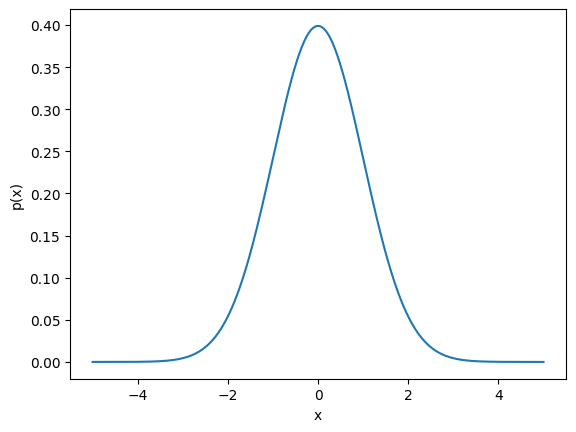

In [8]:
density_1d.plot(xmin = -5, xmax = 5, point_count = 1000)

<Axes3D: >

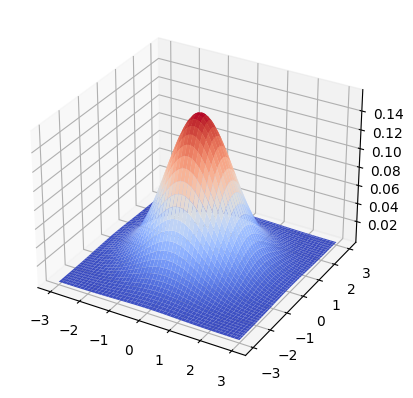

In [9]:
density_2d.plot()

<Axes: >

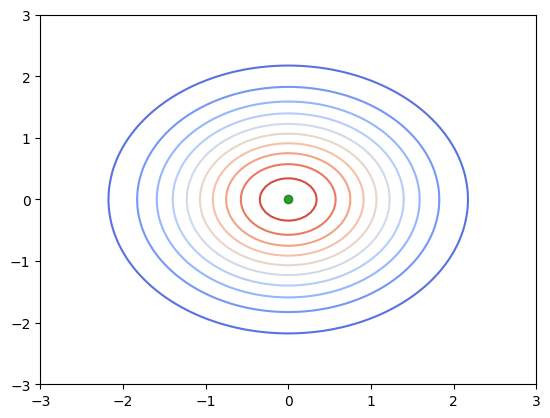

In [10]:
density_2d.plot_contour()

We now extend the Density class to implement a Mixture of densities:

In [11]:
class Mixture(Density):
  def __init__(self, densities, weights):
    if type(weights) == list:
      weights = np.array(weights)
    assert len(densities) == len(weights), "must provide one weight for each density"
    assert np.sum(weights) == 1, "weights must sum up to 1"
    assert not np.any(weights < 0), "weights must be >= 0"
    
    assert np.all(np.array([comp.dim for comp in densities]) == densities[0].dim), "all mixture components must have the same dimensionality"

    self.dim = densities[0].dim

    self.densities = densities
    self.weights = weights

  def plot_mixture(self, xmin = -10, xmax = 10, ymin = -10, ymax = -10, plot_components = True, plot_mixture = True):
    densities, weights = self.densities, self.weights

    if self.dim == 1:
      plot_fn = self.plot_1d
      plot_fn_str = "plot_1d"
    else:
      plot_fn = self.plot_contour
      plot_fn_str = "plot_contour"

    ax = self.prepare_ax(None)

    if plot_mixture:
      if plot_fn_str == "plot_1d":
        ax = plot_fn(xmin = xmin, xmax = xmax, label = "GMM", c = "black", zorder = 10, ax = ax)
      else:
        ax = plot_fn(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, label = "GMM", c = "black", zorder = 10, ax = ax)

    if plot_components:
      for id, (density, weight) in enumerate(zip(densities, weights)):
        if plot_fn_str == "plot_1d":
          density.plot_1d(xmin = xmin, xmax = xmax, scale = weight, linestyle = "dashed", ax = ax, label = f'Component {id}')
        else:
          ax = density.plot_contour(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, scale = weight, linestyle = "dashed", ax = ax, label = f'Component {id}')

    ax.legend()

    return ax

  def __call__(self, x):
    return np.sum([weight * density(x) for density, weight in zip(self.densities, self.weights)], axis = 0)

  def __len__(self):
    return len(self.densities)

  @classmethod
  def standard(cls, dim, count):
    return cls([GaussianDensity.standard(dim) for _ in range(count)], np.ones(count) / count)

  @classmethod
  def random(cls, dim, count):
    return cls([GaussianDensity(mean = np.random.rand(dim), variance = np.random.rand() * np.eye(dim)) for _ in range(count)], np.ones(count) / count)

  def __str__(self):
    return '\n'.join([str(density) + f' with weight {weight}' for density, weight in zip(self.densities, self.weights)])

In [12]:
density1 = GaussianDensity(-2, 1/2)
density2 = GaussianDensity(1, 2)
density3 = GaussianDensity(4, 1)

weights = [0.5, 0.2, 0.3]

mixt = Mixture([density1, density2, density3], weights)

<Axes: xlabel='x', ylabel='p(x)'>

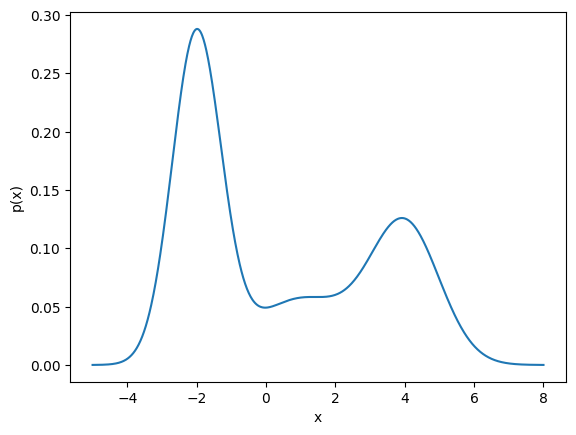

In [13]:
mixt.plot(xmin = -5, xmax = 8)

<Axes: xlabel='x', ylabel='p(x)'>

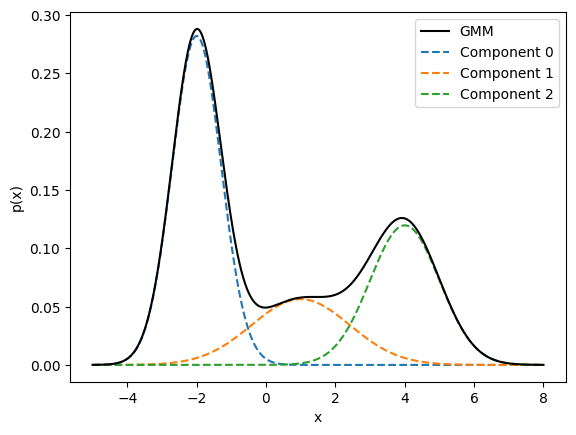

In [14]:
mixt.plot_mixture(xmin = -5, xmax = 8)

<Axes3D: >

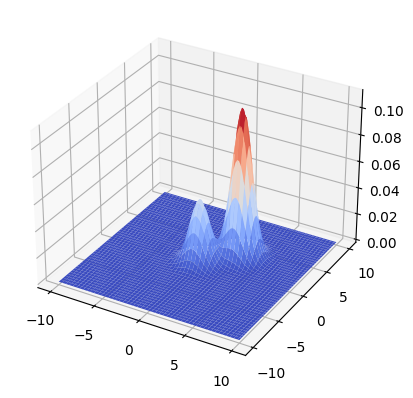

In [15]:
Mixture([GaussianDensity(np.array([0, 0]), np.eye(2)), GaussianDensity(np.array([3, 3]), np.eye(2))], [0.3, 0.7]).plot(xmin = -10, xmax = 10, ymin = -10, ymax = 10)

Let's take some random gaussians and random data and plot the data alongside the mixture model:

In [16]:
gaussian1 = GaussianDensity(-4, 1)
gaussian2 = GaussianDensity(0, 0.2)
gaussian3 = GaussianDensity(8, 3)

In [17]:
weights = np.array([1/3, 1/3, 1/3])

In [18]:
data = np.expand_dims(np.array([-3, -2.5, -1, 0, 2, 4, 5]), 1)

In [19]:
mixt = Mixture([gaussian1, gaussian2, gaussian3], weights)

To fit a mixture to the data, we implement a class for the EM algorithm:

In [20]:
class EM:
  def __init__(self, mixture, data):
    self.mixture = mixture
    self.data = data
    self.cache = dict()
  
  def compute_responsabilities(self):
    component_count = len(self.mixture)
    data_size = len(self.data)
    weights = self.mixture.weights

    top = np.array([self.mixture.densities[i](self.data) for i in range(component_count)]).T
    bottom = np.sum(top * weights, axis = 1)
    
    responsabilities = top * weights / bottom[:, None]
    self.cache["responsabilities"] = responsabilities
    return responsabilities

  def compute_total_responsabilities(self):
    return np.sum(self.cache["responsabilities"], axis = 0)

  def compute_new_means(self):
    responsabilities = self.cache["responsabilities"]
    return responsabilities.T.dot(self.data) / np.sum(responsabilities, axis = 0)[:, None]

  def perform_mean_update(self):
    new_means = self.compute_new_means()
    for density, new_mean in zip(self.mixture.densities, new_means):
      density.mean = new_mean

  def compute_new_variances(self):
    responsabilities = self.cache["responsabilities"]
    total_responsabilities = self.compute_total_responsabilities()
    # extract the means from the components
    means = np.array([component.mean for component in self.mixture.densities])
    variances = np.array([np.sum(responsabilities[:, i].reshape(-1, 1, 1) * np.einsum("... b, d ...", (self.data - means[i]), (self.data - means[i]).T), axis = 0) / total_responsabilities[i] for i in range(len(self.mixture))])
    return variances

  def perform_variance_update(self):
    new_variances = self.compute_new_variances()
    for density, new_variance in zip(self.mixture.densities, new_variances):
      density.variance = new_variance

  def compute_new_weights(self):
    total_responsabilities = self.compute_total_responsabilities()
    return total_responsabilities / len(self.data)

  def perform_weight_update(self):
    new_weights = self.compute_new_weights()
    self.mixture.weights = new_weights

  def fit(self, steps = 100, eps = 0.01, force_steps = True, return_likelihoods = False):
    initial_nll = -self.mixture.log_likelihood(self.data)
    likelihoods = [initial_nll]
    for i in range(steps):
      self.compute_responsabilities()
      self.perform_mean_update()
      self.perform_variance_update()
      self.perform_weight_update()
      updated_nll = -self.mixture.log_likelihood(self.data)
      likelihoods.append(updated_nll)

      if np.allclose(initial_nll, updated_nll, atol=eps, rtol=0):
        if not force_steps:
          break

      initial_nll = updated_nll

    if return_likelihoods:
      return likelihoods

  def plot_fit(self, plot_mixture = True, plot_components = True, xmin = -10, xmax = 10, ymin = -10, ymax = 10):
    ax = self.mixture.plot_mixture(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, plot_mixture = plot_mixture, plot_components = plot_components)
    if self.mixture.dim == 1:
      ax.scatter(self.data, y = np.zeros_like(self.data), c = "blue", zorder = 100)
    else:
      ax.scatter(self.data[:, 0], self.data[:, 1], alpha = 0.3, c = "black")
    return ax

  def likelihood(self):
    return self.mixture.likelihood(self.data)

  def log_likelihood(self):
    return self.mixture.log_likelihood(self.data)

  def plot_colored_by_responsabilities(self):
    plt.scatter(self.data[:, 0], self.data[:, 1], alpha = 1, c = self.cache["responsabilities"])


Let's compute responsabilities for the initial parameters and data:

In [21]:
em = EM(mixt, data)

<Axes: xlabel='x', ylabel='p(x)'>

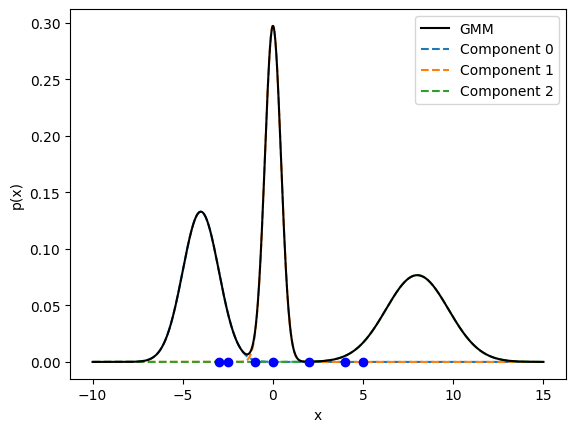

In [22]:
em.plot_fit(xmax = 15)

In [23]:
em.likelihood(), em.log_likelihood()

(4.993167875218718e-13, -28.325535655854626)

In [24]:
responsabilities = em.compute_responsabilities()
responsabilities

array([[1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.057, 0.943, 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 0.066, 0.934],
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   ]])

In [25]:
total_responsabilities = em.compute_total_responsabilities()
total_responsabilities

array([2.057, 2.009, 2.934])

Let's perform a mean update step:

In [26]:
em.compute_new_means()

array([[-2.701],
       [-0.403],
       [ 3.704]])

In [27]:
em.perform_mean_update()

<Axes: xlabel='x', ylabel='p(x)'>

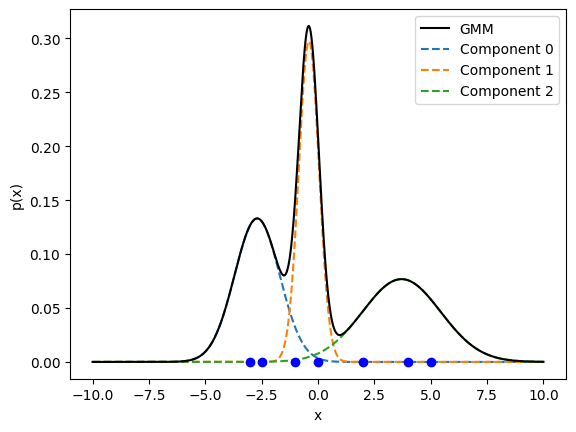

In [28]:
em.plot_fit()

In [29]:
em.log_likelihood()

-16.004150250154286

Let's perform a variance update step:

In [30]:
em.compute_new_variances()

array([[[0.144]],

       [[0.438]],

       [[1.527]]])

In [31]:
em.perform_variance_update()

<Axes: xlabel='x', ylabel='p(x)'>

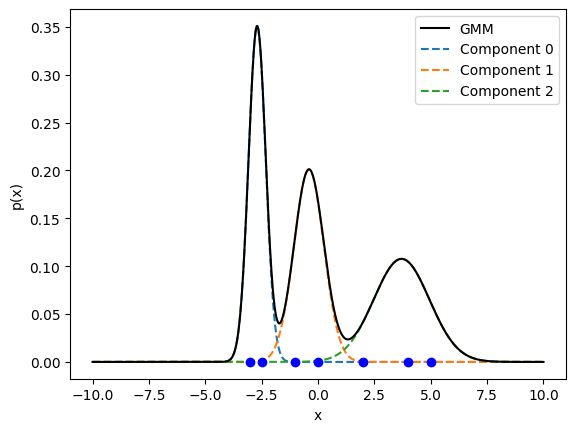

In [32]:
em.plot_fit()

In [33]:
mixt.log_likelihood(data)

-14.547617146369875

Let's perform a weight update step:

In [34]:
em.compute_new_weights()

array([0.294, 0.287, 0.419])

In [35]:
em.perform_weight_update()

<Axes: xlabel='x', ylabel='p(x)'>

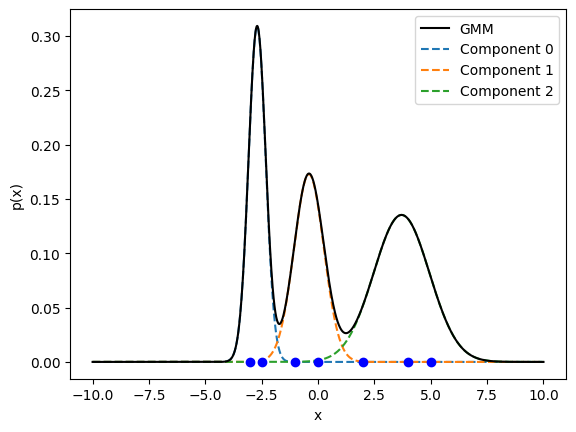

In [36]:
em.plot_fit()

In [37]:
mixt.log_likelihood(data)

-14.410485293107605

Now we reset everything and fit the mixture until the likelihood stops improving:

In [38]:
gaussian1 = GaussianDensity(-4, 1)
gaussian2 = GaussianDensity(0, 0.2)
gaussian3 = GaussianDensity(8, 3)

weights = np.array([1/3, 1/3, 1/3])

mixt = Mixture([gaussian1, gaussian2, gaussian3], weights)

In [39]:
em2 = EM(mixt, data)

In [40]:
nlls = em2.fit(steps = 5, return_likelihoods = True)

In [41]:
def plot_nll(nll):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.cla()
  ax.ticklabel_format(style='plain') 
  ax.set_xlabel("Iteration")
  ax.set_ylabel("Negative log-likelihood")
  ax.plot(nll, marker="o")

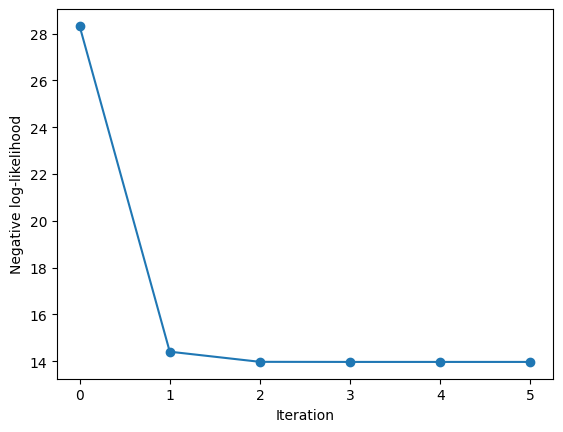

In [42]:
plot_nll(nlls)

<Axes: xlabel='x', ylabel='p(x)'>

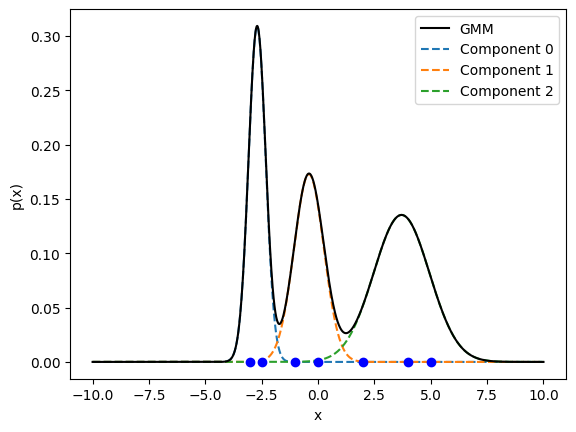

In [43]:
em.plot_fit()

In [44]:
print(em.mixture)

mean [-2.701] and variance [0.144] with weight 0.2938897515527169
mean [-0.403] and variance [0.438] with weight 0.2870012060356117
mean [3.704] and variance [1.527] with weight 0.4191090424116715


Let's plot some random points generated from $3$ gaussians with some overlap:

In [45]:
def generate_dataset(gaussians, points_per_component = 500):
  points = np.concatenate([gaussian.sample(points_per_component) for gaussian in gaussians])
  return points

In [46]:
points = generate_dataset([
  GaussianDensity(np.array([-4, 1]), np.array([[1, -0.5], [-0.5, 0.5]])), 
  GaussianDensity(np.array([2, 0]), np.array([[1, -0.5], [-0.5, 1]])),
  GaussianDensity(np.array([5, 0]), np.array([[1, 0.5], [0.5, 3]]))
])

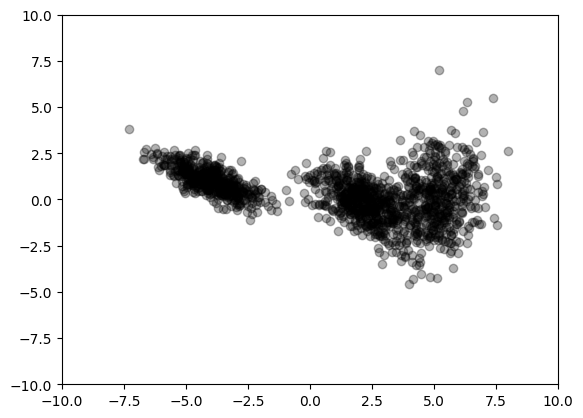

In [47]:
plt.axis([-10, 10, -10, 10])
plt.scatter(points[:, 0], points[:, 1], alpha = 0.3, c = "black")

Let's try to fit a single Gaussian to the data:

In [48]:
mixt = Mixture.random(2, 1)

In [49]:
em = EM(mixt, points)

In [50]:
likelihoods = em.fit(return_likelihoods = True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


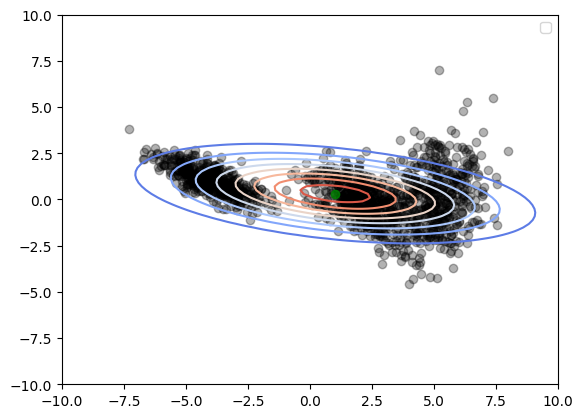

In [51]:
ax = em.plot_fit(plot_components = True, plot_mixture = False)

In [72]:
mixt = Mixture.random(2, 3)

In [73]:
em = EM(mixt, points)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: >

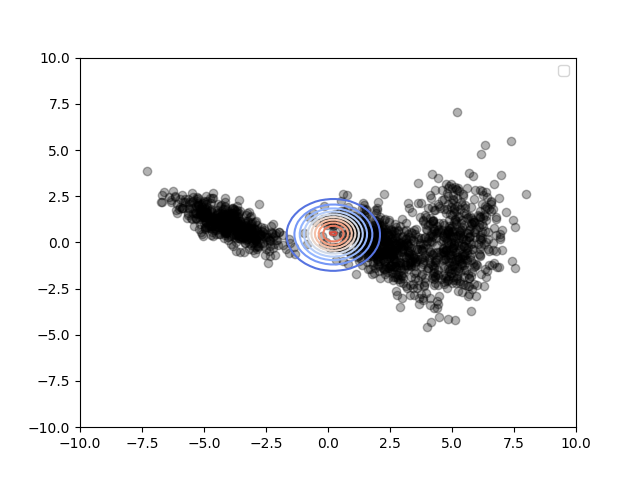

In [74]:
em.plot_fit(plot_components = False, plot_mixture = True)

In [75]:
likelihoods = em.fit(return_likelihoods = True)

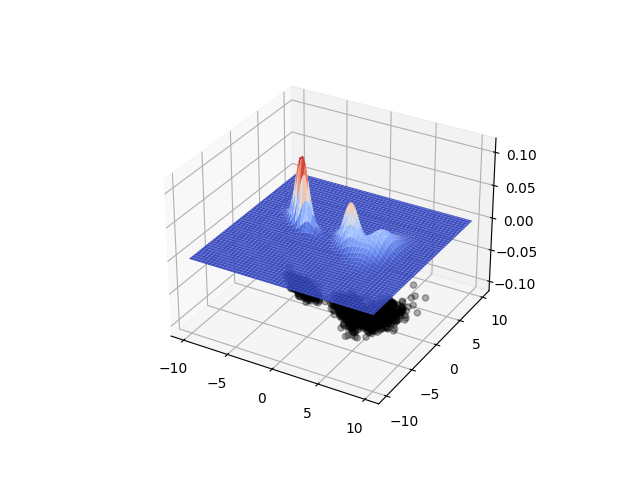

In [76]:
%matplotlib widget
ax = em.mixture.plot(xmin = -10, xmax = 10, ymin = -10, ymax = 10)
ax.scatter(points[:, 0], points[:, 1], zs = -0.1, alpha = 0.3, c = "black")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: >

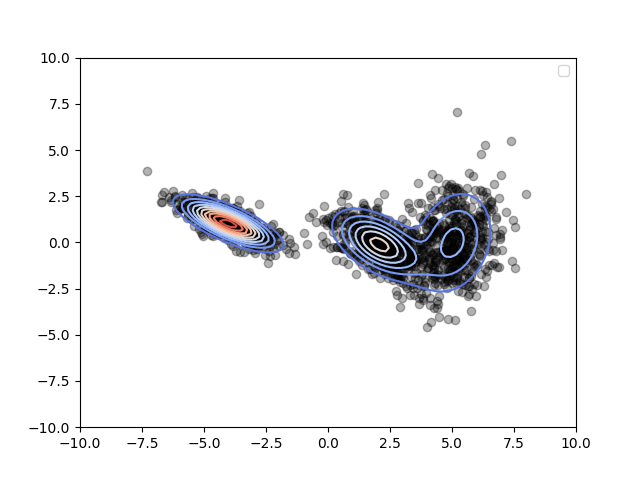

In [60]:
em.plot_fit(plot_components = False, plot_mixture = True)

In [61]:
print(mixt)

mean [ 2.065 -0.102] and variance [ 0.964 -0.506 -0.506  0.994] with weight 0.33887136484312375
mean [-4.021  1.029] and variance [ 1.051 -0.548 -0.548  0.519] with weight 0.3333319209205421
mean [5.052 0.023] and variance [0.927 0.36  0.36  2.81 ] with weight 0.3277967142363341


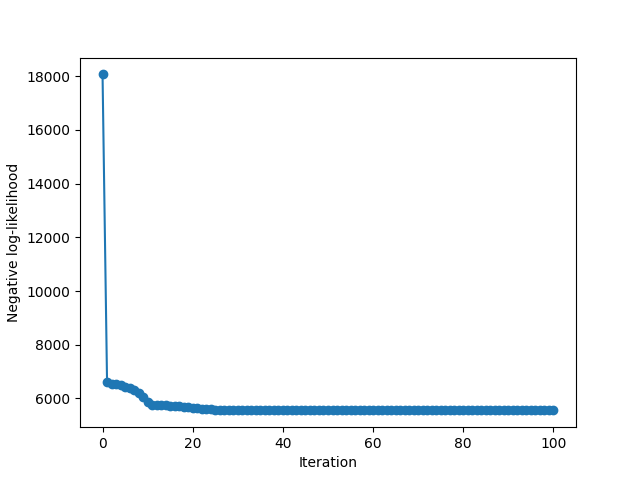

In [78]:
plt.clf()
plot_nll(likelihoods)

In [63]:
em.plot_colored_by_responsabilities()

Let's now try to run only until convergence:

In [64]:
mixt2 = Mixture.random(2, 3)
em2 = EM(mixt2, points)

In [65]:
nll = em2.fit(force_steps = False, eps = 0.01, return_likelihoods = True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: >

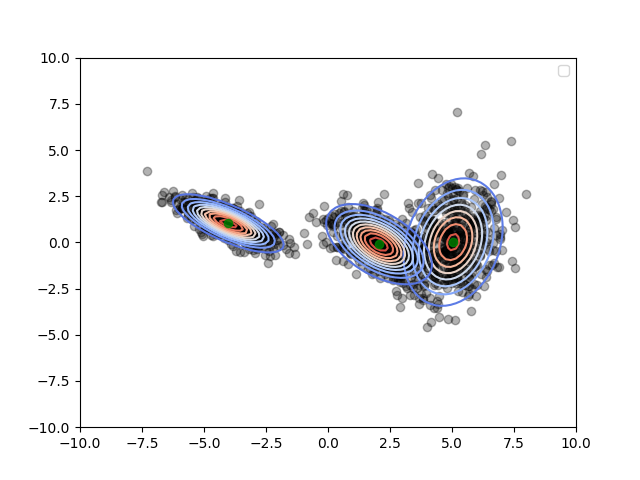

In [66]:
em2.plot_fit(plot_components = True, plot_mixture = False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: >

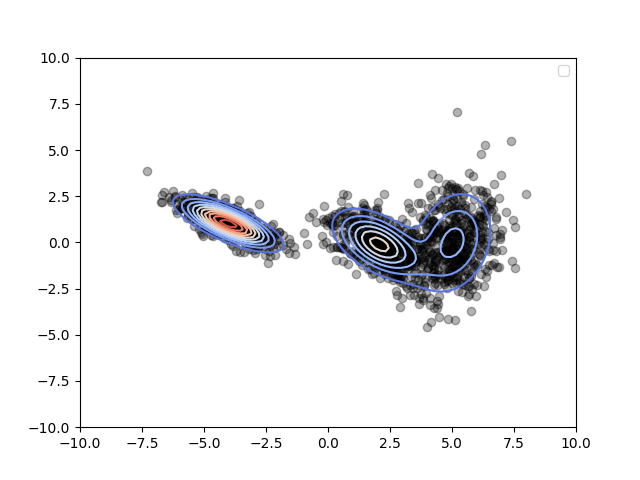

In [67]:
em2.plot_fit(plot_components = False, plot_mixture = True)

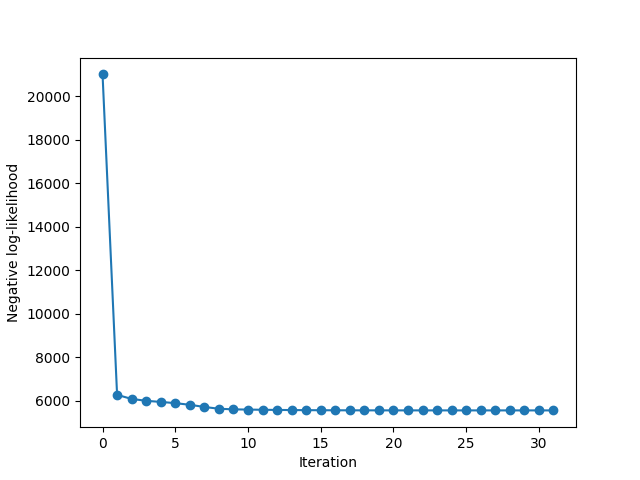

In [68]:
plot_nll(nll)